In [58]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.colors as pc
from modified_spectral_method import *
from modified_louvain_method import *
import cvxpy as cp
import copy
import matplotlib.pyplot as plt

#### Coefficient Calculation Methods

In [3]:
# function to calculate proxy using the intersection method
def calculate_coefficients_intersection_method(prices_data, metadata, index_data, liquid_bucket, date, use_index = False):

    company_communities = metadata['Ticker'].to_list()
    metadata = metadata.set_index('Ticker')

    # prepare the data for the date
    prices_data = prices_data.loc[date,:]

    # prepare index data for the date
    index_data.rename(columns={'AsOf':'Date'}, inplace=True)
    index_data['Date'] = pd.to_datetime(index_data['Date'], format='%d/%b/%y')
    index_data = index_data.sort_values(by='Date', ascending=True)
    index_data = index_data[index_data['Date'] == date]
    index_spread = index_data['ConvSpread'].values[0]
    # print(f"Index spread for the date {date} is {index_spread}")

    # prepare the liquid bucket data for the date
    liquid_bucket_sector = liquid_bucket['Sector']
    liquid_bucket_country = liquid_bucket['Country']
    liquid_bucket_ratings = liquid_bucket['Rating']
    liquid_bucket_tickers = metadata[(metadata['Sector'] == liquid_bucket_sector) & (metadata['Country'] == liquid_bucket_country) & (metadata['AverageRating'] == liquid_bucket_ratings)].index.to_list()
    liquid_bucket_spread = prices_data[liquid_bucket_tickers].mean(axis=0)
    print(f"Liquid bucket spread for the date {date} is {liquid_bucket_spread}")

    if use_index:
        global_spread = index_spread
    else:
        global_spread = liquid_bucket_spread

    # create all possible combinations of the buckets
    unique_buckets = []

    for i in range(len(company_communities)):
        bucket = f'{metadata.loc[company_communities[i], 'Sector']}, {metadata.loc[company_communities[i], 'Country']}, {metadata.loc[company_communities[i], 'AverageRating']}'
        if bucket not in unique_buckets:
            unique_buckets.append(bucket)
    if not use_index:
        # remove the liquid bucket from the unique buckets
        unique_buckets.remove(f'{liquid_bucket_sector}, {liquid_bucket_country}, {liquid_bucket_ratings}')

    # prepare the prices data and the indicator matrix
    prices_data = prices_data.T.to_numpy()
    prices_data = prices_data.reshape(-1, 1)

    # create the indicator matrix
    indicators = np.zeros((len(company_communities), len(unique_buckets)))
    for i in range(len(company_communities)):
        # create string for the bucket
        bucket = f'{metadata.loc[company_communities[i], 'Sector']}, {metadata.loc[company_communities[i], 'Country']}, {metadata.loc[company_communities[i], 'AverageRating']}'
        if bucket in unique_buckets:
            j = unique_buckets.index(bucket)
            indicators[i, j] = 1

    # a_0
    a_0 = np.tile(global_spread, (len(company_communities), 1))

    # create optimization variables
    betas = cp.Variable(shape=(len(unique_buckets), 1))

    beta_contributions = indicators @ betas

    # Define the objective function
    objective = cp.Minimize(cp.norm(prices_data - a_0 - beta_contributions, "fro")**2)

    # Solve the optimization problem
    problem = cp.Problem(objective)
    problem.solve()

    # store the coefficients
    coefficients = pd.DataFrame({'bucket': unique_buckets, 'Coefficient': betas.value.flatten()})
    coefficients = coefficients.set_index('bucket')

    return coefficients

In [4]:
# function to calculate proxy using the CSRA community method
def calculate_proxy_coeff_csra_community(prices_data, communities, metadata, index_data, liquid_bucket, date, use_index = False):
    if not isinstance(communities[0], list):
        communities = [communities]
    coefficients = {}
    metadata = metadata.set_index('Ticker')
    # prepare the data for the date
    prices_data = prices_data.loc[date,:]

    # prepare index data for the date
    index_data.rename(columns={'AsOf':'Date'}, inplace=True)
    index_data['Date'] = pd.to_datetime(index_data['Date'], format='%d/%b/%y')
    index_data = index_data.sort_values(by='Date', ascending=True)
    index_data = index_data[index_data['Date'] == date]
    index_spread = index_data['ConvSpread'].values[0]
    # print(f"Index spread for the date {date} is {index_spread}")

    # prepare the liquid bucket data for the date
    liquid_bucket_sector = liquid_bucket['Sector']
    liquid_bucket_country = liquid_bucket['Country']
    liquid_bucket_ratings = liquid_bucket['Rating']
    liquid_bucket_tickers = metadata[(metadata['Sector'] == liquid_bucket_sector) & (metadata['Country'] == liquid_bucket_country) & (metadata['AverageRating'] == liquid_bucket_ratings)].index.to_list()
    liquid_bucket_spread = prices_data[liquid_bucket_tickers].mean(axis=0)

    # print(f"Liquid bucket spread for the date {date} is {liquid_bucket_spread}")

    if use_index:
        global_spread = index_spread
    else:
        global_spread = liquid_bucket_spread
    
    for community_number, community in enumerate(communities):

        # prepare the data for the community
        prices_data_community = prices_data[community]
        metadata_community = metadata.loc[community,:]

        sectors_community = metadata_community.loc[community, 'Sector'].unique().tolist()

        countries_community = metadata_community.loc[community, 'Country'].unique().tolist()

        ratings_community = metadata_community.loc[community, 'AverageRating'].unique().tolist()

        # remove the liquid bucket from the community
        if not use_index:
            if liquid_bucket_sector in sectors_community:
                sectors_community.remove(liquid_bucket_sector)
            if liquid_bucket_country in countries_community:
                countries_community.remove(liquid_bucket_country)
            if liquid_bucket_ratings in ratings_community:
                ratings_community.remove(liquid_bucket_ratings)

        prices_data_community = prices_data_community.T.to_numpy()
        prices_data_community = prices_data_community.reshape(-1, 1)

        # tranform the data to the log space
        prices_data_community_log = np.log(prices_data_community)
        # create the masks
        mask = np.zeros((prices_data_community.shape[0], len(sectors_community) + len(countries_community) + len(ratings_community)))

        for i in range(prices_data_community.shape[0]):
            if not use_index:
                if metadata_community.loc[community[i], 'Sector'] in sectors_community:
                    j = sectors_community.index(metadata_community.loc[community[i], 'Sector'])
                    mask[i, j] = 1
                if metadata_community.loc[community[i], 'Country'] in countries_community:
                    j = len(sectors_community) + countries_community.index(metadata_community.loc[community[i], 'Country']) - 1
                    mask[i, j] = 1
                if metadata_community.loc[community[i], 'AverageRating'] in ratings_community:
                    j = len(sectors_community) + len(countries_community) + ratings_community.index(metadata_community.loc[community[i], 'AverageRating']) - 1
                    mask[i, j] = 1


            else:    
                j = sectors_community.index(metadata_community.loc[community[i], 'Sector'])
                mask[i, j] = 1
                k = len(sectors_community) + countries_community.index(metadata_community.loc[community[i], 'Country'])  - 1
                mask[i, k] = 1
                l = len(sectors_community) + len(countries_community) + ratings_community.index(metadata_community.loc[community[i], 'AverageRating']) - 1

        # beta_0
        beta_0 = np.tile(np.log(global_spread), (prices_data_community.shape[1], 1))

        # Define optimization variables
        betas = cp.Variable(shape=(len(sectors_community) + len(countries_community) + len(ratings_community), 1))

        beta_contributions = mask @ betas

        # Define the objective function
        objective = cp.Minimize(cp.norm(prices_data_community_log - beta_0 -  beta_contributions, "fro")**2)


        # Solve the optimization problem
        problem = cp.Problem(objective)
        problem.solve()

        # store the coefficients
        sector_betas = betas.value[0:len(sectors_community)]
        country_betas = betas.value[len(sectors_community): len(sectors_community) + len(countries_community)]
        rating_betas = betas.value[len(sectors_community) + len(countries_community):]

        sectors_df = pd.DataFrame({'Name': sectors_community, 'Coefficient': sector_betas.flatten(), 'Type': 'Sector'},)
        countries_df = pd.DataFrame({'Name': countries_community, 'Coefficient': country_betas.flatten(), 'Type': 'Country'})
        ratings_df = pd.DataFrame({'Name': ratings_community, 'Coefficient': rating_betas.flatten(), 'Type': 'Rating'}) 

        # Combine DataFrames
        coefficients_df = pd.concat([sectors_df, countries_df, ratings_df], ignore_index=True)
        coefficients_df = coefficients_df.set_index('Name')
        coefficients[f'community_{community_number+1}'] = coefficients_df
    
    return coefficients

#### Proxy Calculation Methods

In [70]:
def calculate_proxy_intersection_method(ticker, metadata, coefficients, prices_data, index_data, liquid_bucket, date, use_index = False):
    metadata = metadata.set_index('Ticker')
    # prepare the data for the date
    prices_data = prices_data.loc[date,:]

    # prepare index data for the date
    index_data.rename(columns={'AsOf':'Date'}, inplace=True)
    index_data['Date'] = pd.to_datetime(index_data['Date'], format='%d/%b/%y')
    index_data = index_data.sort_values(by='Date', ascending=True)
    index_data = index_data[index_data['Date'] == date]
    index_spread = index_data['ConvSpread'].values[0]
    # print(f"Index spread for the date {date} is {index_spread}")

    # prepare the liquid bucket data for the date
    liquid_bucket_sector = liquid_bucket['Sector']
    liquid_bucket_country = liquid_bucket['Country']
    liquid_bucket_ratings = liquid_bucket['Rating']
    liquid_bucket_tickers = metadata[(metadata['Sector'] == liquid_bucket_sector) & (metadata['Country'] == liquid_bucket_country) & (metadata['AverageRating'] == liquid_bucket_ratings)].index.to_list()
    liquid_bucket_spread = prices_data[liquid_bucket_tickers].mean(axis=0)
    # print(f"Liquid bucket spread for the date {date} is {liquid_bucket_spread}")

    if use_index:
        global_spread = index_spread
    else:
        global_spread = liquid_bucket_spread
    company_bucket = f'{metadata.loc[ticker, 'Sector']}, {metadata.loc[ticker, 'Country']}, {metadata.loc[ticker, 'AverageRating']}'

    if company_bucket not in coefficients.index:
        print(f"Bucket not found for Company {ticker} ")
        return global_spread
    else:
        print(f"Bucket FOUND for Company {ticker} ")
        coefficient = coefficients.loc[company_bucket, 'Coefficient']

        proxy = coefficient + global_spread

    return proxy

In [7]:
def calculate_proxy_csra_community(ticker,  metadata, coefficients, ticker_community, prices_data, index_data, liquid_bucket, date, use_index = False):
    metadata = metadata.set_index('Ticker')
    # prepare the data for the date
    prices_data = prices_data.loc[date,:]

    # prepare index data for the date
    index_data.rename(columns={'AsOf':'Date'}, inplace=True)
    index_data['Date'] = pd.to_datetime(index_data['Date'], format='%d/%b/%y')
    index_data = index_data.sort_values(by='Date', ascending=True)
    index_data = index_data[index_data['Date'] == date]
    index_spread = index_data['ConvSpread'].values[0]
    # print(f"Index spread for the date {date} is {index_spread}")

    # prepare the liquid bucket data for the date
    liquid_bucket_sector = liquid_bucket['Sector']
    liquid_bucket_country = liquid_bucket['Country']
    liquid_bucket_ratings = liquid_bucket['Rating']
    liquid_bucket_tickers = metadata[(metadata['Sector'] == liquid_bucket_sector) & (metadata['Country'] == liquid_bucket_country) & (metadata['AverageRating'] == liquid_bucket_ratings)].index.to_list()
    liquid_bucket_spread = prices_data[liquid_bucket_tickers].mean(axis=0)
    # print(f"Liquid bucket spread for the date {date} is {liquid_bucket_spread}")

    if use_index:
        global_spread = np.log(index_spread)
    else:
        global_spread = np.log(liquid_bucket_spread)

    company_community = f'community_{ticker_community}'
    coefficients_ticker_community = coefficients[company_community]

    # get the coefficients for the sector, country and rating
    if metadata.loc[ticker, 'Sector'] in coefficients_ticker_community.index:
        sector_coefficient = coefficients_ticker_community.loc[metadata.loc[ticker, 'Sector'], 'Coefficient']
    else:
        sector_coefficient = 0
    
    if metadata.loc[ticker, 'Country'] in coefficients_ticker_community.index:
        country_coefficient = coefficients_ticker_community.loc[metadata.loc[ticker, 'Country'], 'Coefficient']
    else:
        country_coefficient = 0

    if metadata.loc[ticker, 'AverageRating'] in coefficients_ticker_community.index:
        rating_coefficient = coefficients_ticker_community.loc[metadata.loc[ticker, 'AverageRating'], 'Coefficient']
    else:
        rating_coefficient = 0

    proxy_log = sector_coefficient + country_coefficient + rating_coefficient + global_spread

    proxy = np.exp(proxy_log)

    return proxy

In [13]:
# load the prices data, index data and metadata 
prices_data = pd.read_csv('data/reshaped_data.csv')
prices_data['Date'] = pd.to_datetime(prices_data['Date'], infer_datetime_format=True)
prices_data = prices_data.set_index('Date')

index_data = pd.read_csv('ITRAXX-Europe Timeseries 20241127.csv')

metadata = pd.read_csv('data/metadata.csv')
 
# perform community detection using the modified spectral method
correlation_matrix,T,N,company_names = create_correlation_matrix('data/eur_data_standardized_returns.csv')
C_g = calculate_C_g(correlation_matrix, T, N)
result_communities, company_communities, modularities = recursive_spectral_method(C_g, correlation_matrix, company_names, min_size=2, modularity_threshold=0.00001)
print(f"number of communities detected:{len(company_communities)}")


C:\Users\iChin\AppData\Local\Temp\ipykernel_14176\3458079704.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  prices_data['Date'] = pd.to_datetime(prices_data['Date'], infer_datetime_format=True)


number of communities detected:3


In [62]:
def get_liquid_bucket(metadata, company_communities, ticker_proxy):
    """
    Get the liquid bucket for a given ticker.

    Parameters:
    - metadata (pd.DataFrame): The metadata dataframe containing ticker information.
    - company_communities (list of lists): A list of communities where each community is a list of tickers.
    - ticker_proxy (str): The ticker for which to calculate the liquid bucket.

    Returns:
    - dict: A dictionary representing the liquid bucket with keys 'Sector', 'Country', and 'Rating', or None if the ticker is not found.
    - int: The community number the ticker belongs to, or None if the ticker is not in any community.
    """
    # Find the community to which the ticker belongs
    ticker_community = None
    for i, community in enumerate(company_communities):
        if ticker_proxy in community:
            ticker_community = i + 1
            break

    if ticker_community is None:
        print(f"Ticker {ticker_proxy} is not part of any community.")
        return None, None

    # Extract the row corresponding to the ticker
    ticker_data = metadata[metadata['Ticker'] == ticker_proxy]

    if ticker_data.empty:
        print(f"Ticker {ticker_proxy} not found in metadata.")
        return None, None

    # Create the liquid bucket using the extracted data
    liquid_bucket = {
        'Sector': ticker_data.iloc[0]['Sector'],
        'Country': ticker_data.iloc[0]['Country'],
        'Rating': ticker_data.iloc[0]['AverageRating']
    }

    return liquid_bucket, ticker_community

In [64]:
ticker_proxy = 'AEGON'
liquid_bucket, community = get_liquid_bucket(metadata, company_communities, ticker_proxy)

date = '2015-12-30'
date = pd.to_datetime(date, format='%Y-%m-%d') # convert the date to pandas datetime format

# get the actual spread for the ticker
actual_spread = prices_data.loc[date, ticker_proxy]
print(f'Actual spread for the ticker {ticker_proxy} is {actual_spread}')

# remove the ticker_proxy from the community data, prices data and metadata
company_communities_proxy_method = copy.deepcopy(company_communities)
print(company_communities_proxy_method[ticker_community-1])
company_communities_proxy_method[ticker_community-1].remove(ticker_proxy)
metadata_proxy_method = metadata[metadata['Ticker'] != ticker_proxy]
prices_data_proxy_method = prices_data.drop(columns= [ticker_proxy])

all_companies = [company for community in company_communities for company in community]
all_companies_proxy_method = [company for community in company_communities_proxy_method for company in community]

# calculate the coefficients and proxy using the intersection method
coefficients_intersection = calculate_coefficients_intersection_method(prices_data_proxy_method, metadata_proxy_method, index_data, liquid_bucket, date, use_index = False)
proxy_intersection = calculate_proxy_intersection_method(ticker_proxy, metadata, coefficients_intersection, prices_data, index_data, liquid_bucket, date, use_index = False)
# print(coefficients)
print(f'calculated proxy using the intersection method: {proxy_intersection}')

# calculate the coefficients and proxy using the CSRA method without the communities
coefficients_csra = calculate_proxy_coeff_csra_community(prices_data_proxy_method, all_companies_proxy_method, metadata_proxy_method, index_data, liquid_bucket, date, use_index = True)
# for key, value in coefficients.items():
#     print(key)
#     print(value)
#     print("")
proxy_csra = calculate_proxy_csra_community(ticker_proxy, metadata, coefficients_csra, 1, prices_data, index_data, liquid_bucket, date, use_index = True)
print(f'calculated proxy using the CSRA method: {proxy_csra}')

# calculate the coefficients and proxy using the CSRA community method
coefficients_csra_community = calculate_proxy_coeff_csra_community(prices_data_proxy_method, company_communities_proxy_method, metadata_proxy_method, index_data, liquid_bucket, date, use_index = True)
proxy_csra_community = calculate_proxy_csra_community(ticker_proxy, metadata, coefficients_csra_community, ticker_community, prices_data, index_data, liquid_bucket, date, use_index = True)
print(f'calculated proxy using the CSRA community method: {proxy_csra_community}')

Actual spread for the ticker AEGON is 77.548
['ACAFP', 'AEGON', 'ALPHBK', 'ALZSE', 'ASSGEN', 'AVLN', 'AXAF', 'BACR-Bank', 'BACRED', 'BBVSM', 'BFCM', 'BNP', 'CMZB', 'CSGAG', 'DANBNK', 'DB', 'DBR', 'EDP', 'ENEL', 'FINL', 'GROUPE', 'IBERDU', 'IRELND', 'MUNRE', 'NSINO', 'OTE', 'PORTUG', 'PRUFIN', 'SANPAO', 'SANTNDR', 'SOCGEN', 'SPAIN', 'STAN-Bank', 'STENA', 'SWREL', 'TELEFO', 'TIIMN', 'UBS', 'UKIN', 'USPA', 'ZINCO']
Liquid bucket spread for the date 2015-12-30 00:00:00 is 111.2459
Bucket not found for Company AEGON 
calculated proxy using the intersection method: 100.01326666666667
calculated proxy using the CSRA method: 169.86545693613488
calculated proxy using the CSRA community method: 89.02177755468622


In [51]:
def calculate_proxies_and_add_to_metadata(metadata, company_communities, prices_data, index_data, liquid_bucket, date):
    """
    Calculates proxy spreads and actual spreads for tickers in metadata and adds them as columns to a copy of metadata.

    Parameters:
    - metadata: pd.DataFrame, contains metadata including tickers.
    - company_communities: list of lists, each inner list is a community containing tickers.
    - prices_data: pd.DataFrame, price data with tickers as columns.
    - index_data: additional index-related data.
    - liquid_bucket: dict, liquid bucket information (e.g., Sector, Country, Rating).
    - date: str or pd.Timestamp, the date for which proxies are calculated.

    Returns:
    - metadata_with_proxies: pd.DataFrame, copy of metadata with calculated proxy and actual spread columns added.
    """
    # Ensure date is in pandas datetime format
    date = pd.to_datetime(date, format='%Y-%m-%d')
    
    # Create a copy of metadata to store results
    metadata_with_proxies = metadata.copy()
    metadata_with_proxies['ActualSpread'] = None
    metadata_with_proxies['ProxyIntersection'] = None
    metadata_with_proxies['ProxyCSRA'] = None
    metadata_with_proxies['ProxyCSRACommunity'] = None

    # Iterate over tickers in metadata
    for ticker_proxy in metadata['Ticker']:
        print(f"\nCalculating proxy for ticker: {ticker_proxy}")

        # Find the community to which the ticker belongs
        ticker_community = None
        for i, community in enumerate(company_communities):
            if ticker_proxy in community:
                ticker_community = i + 1
                break

        # Get the actual spread
        actual_spread = prices_data.loc[date, ticker_proxy]
        print(f"Actual spread for {ticker_proxy}: {actual_spread}")

        # Remove the ticker_proxy from the relevant data structures
        company_communities_proxy_method = copy.deepcopy(company_communities)
        company_communities_proxy_method[ticker_community - 1].remove(ticker_proxy)
        metadata_proxy_method = metadata[metadata['Ticker'] != ticker_proxy]
        prices_data_proxy_method = prices_data.drop(columns=[ticker_proxy])

        # Flatten company communities for proxy method
        all_companies_proxy_method = [company for community in company_communities_proxy_method for company in community]

        # Calculate proxies using intersection and CSRA methods
        try:
            coefficients_intersection = calculate_coefficients_intersection_method(
                prices_data_proxy_method, metadata_proxy_method, index_data, liquid_bucket, date, use_index=False
            )
            proxy_intersection = calculate_proxy_intersection_method(
                ticker_proxy, metadata, coefficients_intersection, prices_data, index_data, liquid_bucket, date, use_index=False
            )
        except Exception as e:
            print(f"Error calculating proxy using intersection method for {ticker_proxy}: {e}")
            proxy_intersection = None

        try:
            coefficients_csra = calculate_proxy_coeff_csra_community(
                prices_data_proxy_method, all_companies_proxy_method, metadata_proxy_method, index_data, liquid_bucket, date, use_index=True
            )
            proxy_csra = calculate_proxy_csra_community(
                ticker_proxy, metadata, coefficients_csra, 1, prices_data, index_data, liquid_bucket, date, use_index=True
            )
        except Exception as e:
            print(f"Error calculating proxy using CSRA method for {ticker_proxy}: {e}")
            proxy_csra = None

        try:
            coefficients_csra_community = calculate_proxy_coeff_csra_community(
                prices_data_proxy_method, company_communities_proxy_method, metadata_proxy_method, index_data, liquid_bucket, date, use_index=True
            )
            proxy_csra_community = calculate_proxy_csra_community(
                ticker_proxy, metadata, coefficients_csra_community, ticker_community, prices_data, index_data, liquid_bucket, date, use_index=True
            )
        except Exception as e:
            print(f"Error calculating proxy using CSRA community method for {ticker_proxy}: {e}")
            proxy_csra_community = None

        # Update the copied metadata with the results
        metadata_with_proxies.loc[metadata_with_proxies['Ticker'] == ticker_proxy, 'ActualSpread'] = actual_spread
        metadata_with_proxies.loc[metadata_with_proxies['Ticker'] == ticker_proxy, 'ProxyIntersection'] = proxy_intersection
        metadata_with_proxies.loc[metadata_with_proxies['Ticker'] == ticker_proxy, 'ProxyCSRA'] = proxy_csra
        metadata_with_proxies.loc[metadata_with_proxies['Ticker'] == ticker_proxy, 'ProxyCSRACommunity'] = proxy_csra_community

    return metadata_with_proxies


In [53]:
metadata_with_proxies = calculate_proxies_and_add_to_metadata(metadata, company_communities, prices_data, index_data, liquid_bucket, date)
metadata_with_proxies.to_csv('data/metadata_with_proxies.csv', index=False)


Calculating proxy for ticker: AAUK
Actual spread for AAUK: 984.6011
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667
Bucket not found for Company AAUK 

Calculating proxy for ticker: ABE
Actual spread for ABE: 112.2037
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667
Bucket not found for Company ABE 

Calculating proxy for ticker: ABHLTD
Actual spread for ABHLTD: 119.4848
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667

Calculating proxy for ticker: ACAFP
Actual spread for ACAFP: 68.0217
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667

Calculating proxy for ticker: ACAFP-CIB
Actual spread for ACAFP-CIB: 65.4582
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667

Calculating proxy for ticker: ACCOR
Actual spread for ACCOR: 102.841
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667

Calculating proxy for ticker: ACEA
Actual sprea

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667

Calculating proxy for ticker: AWLN-AngWatServ
Actual spread for AWLN-AngWatServ: 98.0355
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667

Calculating proxy for ticker: AXAF
Actual spread for AXAF: 55.9697
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667

Calculating proxy for ticker: AYLL
Actual spread for AYLL: 158.3931
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667

Calculating proxy for ticker: AZN
Actual spread for AZN: 38.3575
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667
Bucket not found for Company AZN 

Calculating proxy for ticker: BAB
Actual spread for BAB: 151.147
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company BAB 

Calculating proxy for ticker: BACR-Bank
Actual spread for BACR-Bank: 60.60570000000001
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667

Calculating proxy for ticker: BACRED
Actual spread for BACRED: 129.9474
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667

Calculating proxy for ticker: BAD
Actual spread for BAD: 67.63419999999999
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667
Bucket not found for Company BAD 

Calculating proxy for ticker: BANSAB
Actual spread for BANSAB: 166.3289
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667

Calculating proxy for ticker: BAPLC
Actual spread for BAPLC: 66.6246
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667
Bucket not found for Company BAPLC 

Calculating proxy for ticker: BASFSE
Actual spread for BASFSE: 40.1395
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.013

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(



Calculating proxy for ticker: BPLN
Actual spread for BPLN: 100.8228
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667

Calculating proxy for ticker: BRISA
Actual spread for BRISA: 101.0588
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667
Bucket not found for Company BRISA 

Calculating proxy for ticker: BRITEL-BritTel
Actual spread for BRITEL-BritTel: 78.83609999999999
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667
Bucket not found for Company BRITEL-BritTel 

Calculating proxy for ticker: BRITLD
Actual spread for BRITLD: 126.6716
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667

Calculating proxy for ticker: BRYBDC
Actual spread for BRYBDC: 89.2129
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667
Bucket not found for Company BRYBDC 

Calculating proxy for ticker: BRYBDC-Brew
Actual spread for BRYBDC-Brew: 87.52399999999999
Liquid bucket spread for th

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(



Calculating proxy for ticker: DANBNK
Actual spread for DANBNK: 60.3376
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667
Bucket not found for Company DANBNK 

Calculating proxy for ticker: DANONE
Actual spread for DANONE: 40.74140000000001
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667

Calculating proxy for ticker: DB
Actual spread for DB: 95.15810000000002
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667

Calculating proxy for ticker: DBB
Actual spread for DBB: 17.6764
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667
Bucket not found for Company DBB 

Calculating proxy for ticker: DBR
Actual spread for DBR: 8.0619
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667
Bucket not found for Company DBR 

Calculating proxy for ticker: DENK
Actual spread for DENK: 14.7989
Liquid bucket spread for the date 2015-12-30 00:00:00 is 100.01326666666667
Bucket not f

KeyboardInterrupt: 

In [72]:
def calculate_proxy_time_series_for_ticker(
    ticker, metadata, company_communities, prices_data, index_data, liquid_bucket, date_range
):
    """
    Calculates the time series of proxy values for a specific ticker.

    Parameters:
    - ticker: str, the ticker for which to calculate proxies.
    - metadata: pd.DataFrame, metadata including the ticker.
    - company_communities: list of lists, each inner list is a community containing tickers.
    - prices_data: pd.DataFrame, price data with tickers as columns.
    - index_data: additional index-related data.
    - liquid_bucket: dict, liquid bucket information (e.g., Sector, Country, Rating).
    - date_range: iterable of dates.

    Returns:
    - pd.DataFrame, time series of proxy values for the specified ticker.
    """
    results = []

    for date in date_range:
        try:
            # Ensure the date is in pandas datetime format
            date = pd.to_datetime(date)
            
            # Locate the community for the ticker
            ticker_community = None
            for i, community in enumerate(company_communities):
                if ticker in community:
                    ticker_community = i + 1
                    break
            
            # Calculate actual spread
            actual_spread = prices_data.loc[date, ticker]
            
            # Remove the ticker from proxy calculations
            company_communities_proxy_method = copy.deepcopy(company_communities)
            company_communities_proxy_method[ticker_community - 1].remove(ticker)
            metadata_proxy_method = metadata[metadata['Ticker'] != ticker]
            prices_data_proxy_method = prices_data.drop(columns=[ticker])
            
            # Flatten communities
            all_companies_proxy_method = [
                company for community in company_communities_proxy_method for company in community
            ]

            # Calculate proxies
            proxy_intersection = None
            proxy_csra = None
            proxy_csra_community = None

            try:
                coefficients_intersection = calculate_coefficients_intersection_method(
                    prices_data_proxy_method, metadata_proxy_method, index_data, liquid_bucket, date, use_index=False
                )
                proxy_intersection = calculate_proxy_intersection_method(
                    ticker, metadata, coefficients_intersection, prices_data, index_data, liquid_bucket, date, use_index=False
                )
            except Exception as e:
                print(f"Error calculating intersection proxy for {ticker} on {date}: {e}")
            
            try:
                coefficients_csra = calculate_proxy_coeff_csra_community(
                    prices_data_proxy_method, all_companies_proxy_method, metadata_proxy_method, index_data, liquid_bucket, date, use_index=True
                )
                proxy_csra = calculate_proxy_csra_community(
                    ticker, metadata, coefficients_csra, 1, prices_data, index_data, liquid_bucket, date, use_index=True
                )
            except Exception as e:
                print(f"Error calculating CSRA proxy for {ticker} on {date}: {e}")
            
            try:
                coefficients_csra_community = calculate_proxy_coeff_csra_community(
                    prices_data_proxy_method, company_communities_proxy_method, metadata_proxy_method, index_data, liquid_bucket, date, use_index=True
                )
                proxy_csra_community = calculate_proxy_csra_community(
                    ticker, metadata, coefficients_csra_community, ticker_community, prices_data, index_data, liquid_bucket, date, use_index=True
                )
            except Exception as e:
                print(f"Error calculating CSRA community proxy for {ticker} on {date}: {e}")
            
            # Append results for this date
            results.append({
                "Date": date,
                "ActualSpread": actual_spread,
                "ProxyIntersection": proxy_intersection,
                "ProxyCSRA": proxy_csra,
                "ProxyCSRACommunity": proxy_csra_community,
            })

        except Exception as e:
            print(f"Error calculating proxies for {ticker} on {date}: {e}")
    
    # Convert results to a DataFrame
    return pd.DataFrame(results)

Liquid bucket spread for the date 2015-01-01 00:00:00 is 120.6859668498
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-01-02 00:00:00 is 120.68830534255001
Bucket not found for Company AEGON 
Error calculating proxies for AEGON on 2015-01-03 00:00:00: Timestamp('2015-01-03 00:00:00')
Error calculating proxies for AEGON on 2015-01-04 00:00:00: Timestamp('2015-01-04 00:00:00')
Liquid bucket spread for the date 2015-01-05 00:00:00 is 119.7300762254
Bucket not found for Company AEGON 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Liquid bucket spread for the date 2015-01-06 00:00:00 is 119.3149603459
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-01-07 00:00:00 is 119.47275612165001
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-01-08 00:00:00 is 119.7235627
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-01-09 00:00:00 is 119.35562498614999
Bucket not found for Company AEGON 
Error calculating proxies for AEGON on 2015-01-10 00:00:00: Timestamp('2015-01-10 00:00:00')
Error calculating proxies for AEGON on 2015-01-11 00:00:00: Timestamp('2015-01-11 00:00:00')
Liquid bucket spread for the date 2015-01-12 00:00:00 is 119.49954635980001
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-01-13 00:00:00 is 118.87119440629999
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-01-14 00:00:00 is 118.81481046870002
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-01

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Liquid bucket spread for the date 2015-01-22 00:00:00 is 119.3399709491
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-01-23 00:00:00 is 118.55884264619999
Bucket not found for Company AEGON 
Error calculating proxies for AEGON on 2015-01-24 00:00:00: Timestamp('2015-01-24 00:00:00')
Error calculating proxies for AEGON on 2015-01-25 00:00:00: Timestamp('2015-01-25 00:00:00')
Liquid bucket spread for the date 2015-01-26 00:00:00 is 118.4573969429
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-01-27 00:00:00 is 116.22462914325001
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-01-28 00:00:00 is 116.5886390816
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-01-29 00:00:00 is 116.861772176
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-01-30 00:00:00 is 118.04808705505
Bucket not found for Company AEGON 
Error calculating proxies for AEGON on 2015-01-31 

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Error calculating proxies for AEGON on 2015-04-11 00:00:00: Timestamp('2015-04-11 00:00:00')
Error calculating proxies for AEGON on 2015-04-12 00:00:00: Timestamp('2015-04-12 00:00:00')
Liquid bucket spread for the date 2015-04-13 00:00:00 is 114.67222169835
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-04-14 00:00:00 is 115.0046757513
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-04-15 00:00:00 is 115.56291143199999
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-04-16 00:00:00 is 115.56008992400001
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-04-17 00:00:00 is 116.0897606164
Bucket not found for Company AEGON 
Error calculating proxies for AEGON on 2015-04-18 00:00:00: Timestamp('2015-04-18 00:00:00')
Error calculating proxies for AEGON on 2015-04-19 00:00:00: Timestamp('2015-04-19 00:00:00')
Liquid bucket spread for the date 2015-04-20 00:00:00 is 116.733328261
Bucket n

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-08-26 00:00:00 is 124.13292303225
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-08-27 00:00:00 is 124.03039589755
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-08-28 00:00:00 is 123.14676875580001
Bucket not found for Company AEGON 
Error calculating proxies for AEGON on 2015-08-29 00:00:00: Timestamp('2015-08-29 00:00:00')
Error calculating proxies for AEGON on 2015-08-30 00:00:00: Timestamp('2015-08-30 00:00:00')
Liquid bucket spread for the date 2015-08-31 00:00:00 is 122.9945437659
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-09-01 00:00:00 is 122.90768635325
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-09-02 00:00:00 is 124.01162457419996
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-09-03 00:00:00 is 123.96373578315004
Bucket not found for Company AEGON 
Liquid 

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Error calculating proxies for AEGON on 2015-10-03 00:00:00: Timestamp('2015-10-03 00:00:00')
Error calculating proxies for AEGON on 2015-10-04 00:00:00: Timestamp('2015-10-04 00:00:00')
Liquid bucket spread for the date 2015-10-05 00:00:00 is 120.9502007381
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-10-06 00:00:00 is 120.01755405645
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-10-07 00:00:00 is 119.54411015420001
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-10-08 00:00:00 is 119.37199566385002
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-10-09 00:00:00 is 119.37600445359999
Bucket not found for Company AEGON 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Error calculating proxies for AEGON on 2015-10-10 00:00:00: Timestamp('2015-10-10 00:00:00')
Error calculating proxies for AEGON on 2015-10-11 00:00:00: Timestamp('2015-10-11 00:00:00')
Liquid bucket spread for the date 2015-10-12 00:00:00 is 119.3954596687
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-10-13 00:00:00 is 117.96275199909999
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-10-14 00:00:00 is 119.30841481774999
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-10-15 00:00:00 is 119.3324101819
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-10-16 00:00:00 is 119.31317077150001
Bucket not found for Company AEGON 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Error calculating proxies for AEGON on 2015-10-17 00:00:00: Timestamp('2015-10-17 00:00:00')
Error calculating proxies for AEGON on 2015-10-18 00:00:00: Timestamp('2015-10-18 00:00:00')
Liquid bucket spread for the date 2015-10-19 00:00:00 is 118.35370533015
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-10-20 00:00:00 is 118.03448220909999
Bucket not found for Company AEGON 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Liquid bucket spread for the date 2015-10-21 00:00:00 is 117.99549120145
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-10-22 00:00:00 is 117.92798431944999
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-10-23 00:00:00 is 117.64202291980001
Bucket not found for Company AEGON 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Error calculating proxies for AEGON on 2015-10-24 00:00:00: Timestamp('2015-10-24 00:00:00')
Error calculating proxies for AEGON on 2015-10-25 00:00:00: Timestamp('2015-10-25 00:00:00')
Liquid bucket spread for the date 2015-10-26 00:00:00 is 117.5237244713
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-10-27 00:00:00 is 116.71414865439999
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-10-28 00:00:00 is 116.72562586734999
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-10-29 00:00:00 is 117.72203111785001
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-10-30 00:00:00 is 117.68487008315


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Bucket not found for Company AEGON 
Error calculating proxies for AEGON on 2015-10-31 00:00:00: Timestamp('2015-10-31 00:00:00')
Error calculating proxies for AEGON on 2015-11-01 00:00:00: Timestamp('2015-11-01 00:00:00')
Liquid bucket spread for the date 2015-11-02 00:00:00 is 116.05643979095001
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-11-03 00:00:00 is 115.44903403909998
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-11-04 00:00:00 is 115.21730268005001
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-11-05 00:00:00 is 114.33111316284999
Bucket not found for Company AEGON 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Liquid bucket spread for the date 2015-11-06 00:00:00 is 114.2982843351
Bucket not found for Company AEGON 
Error calculating proxies for AEGON on 2015-11-07 00:00:00: Timestamp('2015-11-07 00:00:00')
Error calculating proxies for AEGON on 2015-11-08 00:00:00: Timestamp('2015-11-08 00:00:00')
Liquid bucket spread for the date 2015-11-09 00:00:00 is 114.33742517565
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-11-10 00:00:00 is 114.30785385340002
Bucket not found for Company AEGON 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Liquid bucket spread for the date 2015-11-11 00:00:00 is 114.213666842
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-11-12 00:00:00 is 114.17154961775
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-11-13 00:00:00 is 114.16766134449999
Bucket not found for Company AEGON 
Error calculating proxies for AEGON on 2015-11-14 00:00:00: Timestamp('2015-11-14 00:00:00')
Error calculating proxies for AEGON on 2015-11-15 00:00:00: Timestamp('2015-11-15 00:00:00')
Liquid bucket spread for the date 2015-11-16 00:00:00 is 114.4652497083
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-11-17 00:00:00 is 114.38100175715
Bucket not found for Company AEGON 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Liquid bucket spread for the date 2015-11-18 00:00:00 is 114.13721879945001
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-11-19 00:00:00 is 114.0018612713
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-11-20 00:00:00 is 113.9223860887
Bucket not found for Company AEGON 
Error calculating proxies for AEGON on 2015-11-21 00:00:00: Timestamp('2015-11-21 00:00:00')
Error calculating proxies for AEGON on 2015-11-22 00:00:00: Timestamp('2015-11-22 00:00:00')
Liquid bucket spread for the date 2015-11-23 00:00:00 is 119.06779999999999
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-11-24 00:00:00 is 119.04630000000002
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-11-25 00:00:00 is 118.11345
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-11-26 00:00:00 is 117.71085000000001
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-11-27 00

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Liquid bucket spread for the date 2015-12-11 00:00:00 is 118.24390000000001
Bucket not found for Company AEGON 
Error calculating proxies for AEGON on 2015-12-12 00:00:00: Timestamp('2015-12-12 00:00:00')
Error calculating proxies for AEGON on 2015-12-13 00:00:00: Timestamp('2015-12-13 00:00:00')
Liquid bucket spread for the date 2015-12-14 00:00:00 is 118.04495
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-12-15 00:00:00 is 118.35765
Bucket not found for Company AEGON 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Liquid bucket spread for the date 2015-12-16 00:00:00 is 117.64124999999999
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-12-17 00:00:00 is 117.96124999999999
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-12-18 00:00:00 is 117.88175000000001
Bucket not found for Company AEGON 
Error calculating proxies for AEGON on 2015-12-19 00:00:00: Timestamp('2015-12-19 00:00:00')
Error calculating proxies for AEGON on 2015-12-20 00:00:00: Timestamp('2015-12-20 00:00:00')
Liquid bucket spread for the date 2015-12-21 00:00:00 is 118.37585000000006
Bucket not found for Company AEGON 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Liquid bucket spread for the date 2015-12-22 00:00:00 is 117.3109
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-12-23 00:00:00 is 117.0695
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-12-24 00:00:00 is 111.05265
Bucket not found for Company AEGON 


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Liquid bucket spread for the date 2015-12-25 00:00:00 is 111.37975
Bucket not found for Company AEGON 
Error calculating proxies for AEGON on 2015-12-26 00:00:00: Timestamp('2015-12-26 00:00:00')
Error calculating proxies for AEGON on 2015-12-27 00:00:00: Timestamp('2015-12-27 00:00:00')
Liquid bucket spread for the date 2015-12-28 00:00:00 is 111.48020000000001
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-12-29 00:00:00 is 111.54745
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-12-30 00:00:00 is 111.2459
Bucket not found for Company AEGON 
Liquid bucket spread for the date 2015-12-31 00:00:00 is 111.3347
Bucket not found for Company AEGON 
          Date  ActualSpread  ProxyIntersection   ProxyCSRA  \
0   2015-01-01     70.964635         104.112189  165.040346   
1   2015-01-02     71.243888         104.206833  164.240626   
2   2015-01-05     74.058090         104.506081  165.081604   
3   2015-01-06     79.675434         106

In [80]:
date_range = pd.date_range(start="2015-01-01", end="2015-12-31", freq="D")
ticker_proxy = "ALZSE"
proxy_time_series = calculate_proxy_time_series_for_ticker(
    ticker = ticker_proxy, 
    metadata=metadata, 
    company_communities=company_communities, 
    prices_data=prices_data, 
    index_data=index_data, 
    liquid_bucket=get_liquid_bucket(metadata, company_communities, ticker_proxy)[0], 
    date_range=date_range
)

print(proxy_time_series)

Liquid bucket spread for the date 2015-01-01 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-01-01 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-01-02 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-01-02 00:00:00: list.remove(x): x not in list
Error calculating proxies for ALZSE on 2015-01-03 00:00:00: Timestamp('2015-01-03 00:00:00')
Error calculating proxies for ALZSE on 2015-01-04 00:00:00: Timestamp('2015-01-04 00:00:00')
Liquid bucket spread for the date 2015-01-05 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-01-05 00:00:00: list.remove(x): x not in list


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Liquid bucket spread for the date 2015-01-06 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-01-06 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-01-07 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-01-07 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-01-08 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-01-08 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-01-09 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-01-09 00:00:00: list.remove(x): x not in list
Error calculating proxies for ALZSE on 2015-01-10 00:00:00: Timestamp('2015-01-10 00:00:00')
Error calculating proxies for ALZSE on 2015-01-11 00:00:00: Timestamp('2015-01-11 00:00:00')
Liquid bucket spread for the date 2015-01-12 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-01-12 00:00:00: list.remove(x): x not in list
Liqu

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Liquid bucket spread for the date 2015-01-22 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-01-22 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-01-23 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-01-23 00:00:00: list.remove(x): x not in list
Error calculating proxies for ALZSE on 2015-01-24 00:00:00: Timestamp('2015-01-24 00:00:00')
Error calculating proxies for ALZSE on 2015-01-25 00:00:00: Timestamp('2015-01-25 00:00:00')
Liquid bucket spread for the date 2015-01-26 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-01-26 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-01-27 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-01-27 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-01-28 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-01-28 00:00:00: list.remove(x): x not in list
Liqu

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Liquid bucket spread for the date 2015-04-15 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-04-15 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-04-16 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-04-16 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-04-17 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-04-17 00:00:00: list.remove(x): x not in list
Error calculating proxies for ALZSE on 2015-04-18 00:00:00: Timestamp('2015-04-18 00:00:00')
Error calculating proxies for ALZSE on 2015-04-19 00:00:00: Timestamp('2015-04-19 00:00:00')
Liquid bucket spread for the date 2015-04-20 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-04-20 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-04-21 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-04-21 00:00:00: list.remove(x): x not in list
Liqu

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Liquid bucket spread for the date 2015-10-21 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-10-21 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-10-22 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-10-22 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-10-23 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-10-23 00:00:00: list.remove(x): x not in list


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Error calculating proxies for ALZSE on 2015-10-24 00:00:00: Timestamp('2015-10-24 00:00:00')
Error calculating proxies for ALZSE on 2015-10-25 00:00:00: Timestamp('2015-10-25 00:00:00')
Liquid bucket spread for the date 2015-10-26 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-10-26 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-10-27 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-10-27 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-10-28 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-10-28 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-10-29 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-10-29 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-10-30 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-10-30 00:00:00: list.remove(x): x not in list
Erro

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Liquid bucket spread for the date 2015-11-03 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-11-03 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-11-04 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-11-04 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-11-05 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-11-05 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-11-06 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-11-06 00:00:00: list.remove(x): x not in list
Error calculating proxies for ALZSE on 2015-11-07 00:00:00: Timestamp('2015-11-07 00:00:00')
Error calculating proxies for ALZSE on 2015-11-08 00:00:00: Timestamp('2015-11-08 00:00:00')
Liquid bucket spread for the date 2015-11-09 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-11-09 00:00:00: list.remove(x): x not in list
Liqu

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Liquid bucket spread for the date 2015-12-09 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-12-09 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-12-10 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-12-10 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-12-11 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-12-11 00:00:00: list.remove(x): x not in list
Error calculating proxies for ALZSE on 2015-12-12 00:00:00: Timestamp('2015-12-12 00:00:00')
Error calculating proxies for ALZSE on 2015-12-13 00:00:00: Timestamp('2015-12-13 00:00:00')
Liquid bucket spread for the date 2015-12-14 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-12-14 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-12-15 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-12-15 00:00:00: list.remove(x): x not in list
Liqu

C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Liquid bucket spread for the date 2015-12-17 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-12-17 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-12-18 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-12-18 00:00:00: list.remove(x): x not in list
Error calculating proxies for ALZSE on 2015-12-19 00:00:00: Timestamp('2015-12-19 00:00:00')
Error calculating proxies for ALZSE on 2015-12-20 00:00:00: Timestamp('2015-12-20 00:00:00')
Liquid bucket spread for the date 2015-12-21 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-12-21 00:00:00: list.remove(x): x not in list


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Liquid bucket spread for the date 2015-12-22 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-12-22 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-12-23 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-12-23 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-12-24 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-12-24 00:00:00: list.remove(x): x not in list


C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\iChin\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Liquid bucket spread for the date 2015-12-25 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-12-25 00:00:00: list.remove(x): x not in list
Error calculating proxies for ALZSE on 2015-12-26 00:00:00: Timestamp('2015-12-26 00:00:00')
Error calculating proxies for ALZSE on 2015-12-27 00:00:00: Timestamp('2015-12-27 00:00:00')
Liquid bucket spread for the date 2015-12-28 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-12-28 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-12-29 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-12-29 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-12-30 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-12-30 00:00:00: list.remove(x): x not in list
Liquid bucket spread for the date 2015-12-31 00:00:00 is nan
Error calculating intersection proxy for ALZSE on 2015-12-31 00:00:00: list.remove(x): x not in list
    

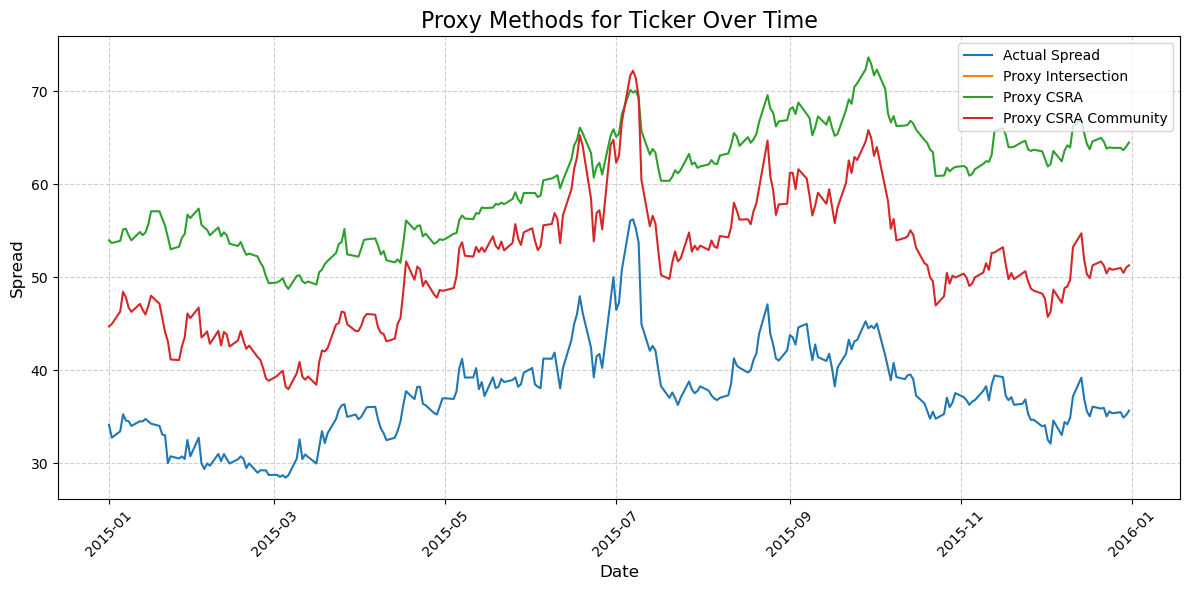

In [94]:
# Plotting the time series of the proxy methods
plt.figure(figsize=(12, 6))

# Plot each proxy method and actual spread
plt.plot(proxy_time_series['Date'], proxy_time_series['ActualSpread'], label='Actual Spread')
plt.plot(proxy_time_series['Date'], proxy_time_series['ProxyIntersection'], label='Proxy Intersection')
plt.plot(proxy_time_series['Date'], proxy_time_series['ProxyCSRA'], label='Proxy CSRA')
plt.plot(proxy_time_series['Date'], proxy_time_series['ProxyCSRACommunity'], label='Proxy CSRA Community')

# Adding title and labels
plt.title(f"Proxy Methods for Ticker Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Spread", fontsize=12)

# Adding grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc="upper right", fontsize=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


In [88]:
def calculate_rmse(actual_spread, proxy_spread):
    """
    Calculate the RMSE between actual spreads and proxy spreads.

    Parameters:
    - actual_spread (pd.Series or np.array): The actual spreads (\( \hat{S}_j \)).
    - proxy_spread (pd.Series or np.array): The proxy spreads (\( S_j^{proxy} \)).

    Returns:
    - float: The RMSE value.
    """
    # Ensure the inputs are numpy arrays
    actual_spread = np.array(actual_spread)
    proxy_spread = np.array(proxy_spread)
    
    # Calculate the squared differences
    squared_differences = (actual_spread - proxy_spread) ** 2
    
    # Calculate the mean of squared differences
    mean_squared_error = np.mean(squared_differences)
    
    # Return the square root of the mean squared error
    return np.sqrt(mean_squared_error)

# Example usage with proxy_time_series DataFrame
rmse_csra = calculate_rmse(proxy_time_series['ActualSpread'], proxy_time_series['ProxyCSRA'])
rmse_csra_community = calculate_rmse(proxy_time_series['ActualSpread'], proxy_time_series['ProxyCSRACommunity'])

print(f"RMSE for Proxy CSRA: {rmse_csra}")
print(f"RMSE for Proxy CSRA Community: {rmse_csra_community}")

RMSE for Proxy CSRA: 23.186260677008388
RMSE for Proxy CSRA Community: 14.28839648921616


<>:2: SyntaxWarning: invalid escape sequence '\('
<>:2: SyntaxWarning: invalid escape sequence '\('
C:\Users\iChin\AppData\Local\Temp\ipykernel_14176\1474105382.py:2: SyntaxWarning: invalid escape sequence '\('
  """
